# Model
qwen2.5-coder:32b 

## Prompt 1:
/ask there are 2 jpg files in image. directory. ./image/img_left.jpg and ./image/img_right.jpg. I would like to use OpenCV in Python (jupyter) to identify features in both images using Sift and then matching them and displaying the matches on the jupyter cell. Can you help write the code?

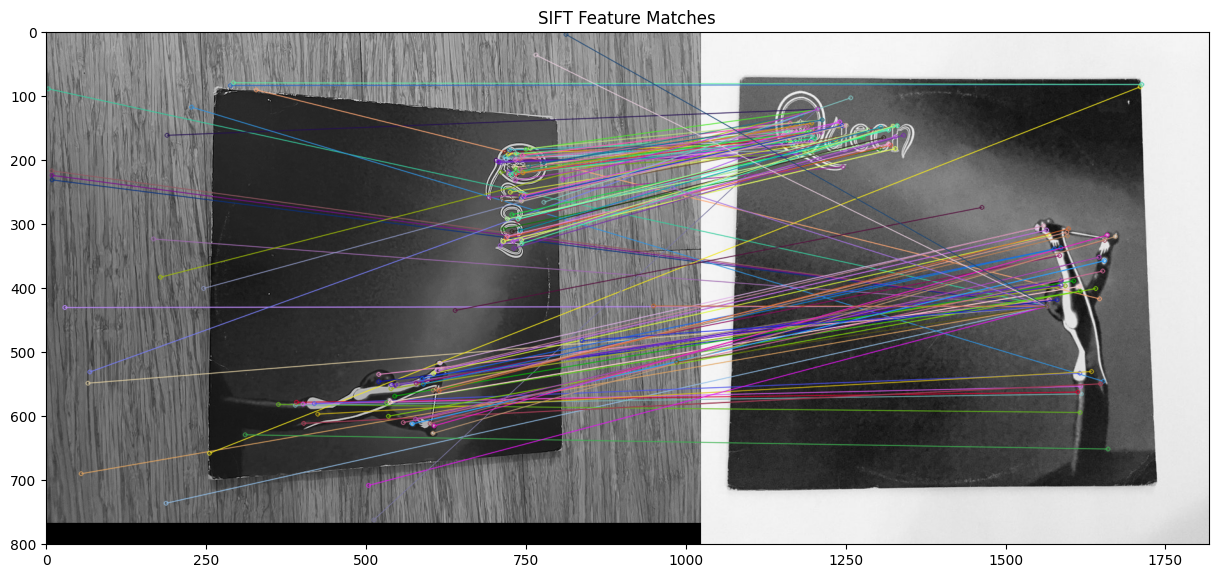

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load images in grayscale mode
img_left = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)

if img_left is None or img_right is None:
    raise ValueError("One of the image files could not be loaded. Please check the file paths.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors with SIFT
keypoints_left, descriptors_left = sift.detectAndCompute(img_left, None)
keypoints_right, descriptors_right = sift.detectAndCompute(img_right, None)

# Create FLANN-based matcher object
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors
matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

# Store all the good matches as per Lowe's ratio test.
good_matches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

# Draw matches
img_matches = cv2.drawMatches(img_left, keypoints_left, img_right, keypoints_right,
                              good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the result
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('SIFT Feature Matches')
plt.show()

## Prompt 2
This is pretty great. I heard that there is a RANSAC algorithm to eliminate flast matches. Can you improve the code with this algorithm?

## Prompt 4
can you put all the code in one place? I mean combining the two answers


In [3]:
import cv2
import numpy as np

# Load two images
img1 = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images are loaded properly
if img1 is None or img2 is None:
    raise ValueError("Images not found or unable to load.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Use BFMatcher with cross-check to find matches
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test to filter out bad matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Number of initial matches: {len(good_matches)}")

# Extract location of good matches
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

# Apply RANSAC to find the homography matrix
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # 5.0 is a threshold value

# Convert the mask to boolean and extract the inlier matches
matchesMask = mask.ravel().tolist()
inliers = [m for i, m in enumerate(good_matches) if matchesMask[i]]

print(f"Number of inliers: {len(inliers)}")

# Draw only the inliers on the image
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, inliers, None, **draw_params)

# Display the image
cv2.imshow('Inlier Matches', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()

Number of initial matches: 162
Number of inliers: 108


error: OpenCV(4.11.0) /io/opencv/modules/features2d/src/draw.cpp:228: error: (-201:Incorrect size of input array) matchesMask must have the same size as matches1to2 in function 'drawMatches'


# Prompt 5

/fix

In [4]:
import cv2
import numpy as np

# Load two images
img1 = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images are loaded properly
if img1 is None or img2 is None:
    raise ValueError("Images not found or unable to load.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Use BFMatcher with cross-check to find matches
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test to filter out bad matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Number of initial matches: {len(good_matches)}")

# Extract location of good matches
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

# Apply RANSAC to find the homography matrix
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # 5.0 is a threshold value

# Convert the mask to boolean and extract the inlier matches
matchesMask = mask.ravel().tolist()
inliers = [m for i, m in enumerate(good_matches) if matchesMask[i]]

print(f"Number of inliers: {len(inliers)}")

# Create a new matchesMask that only includes inliers
new_matches_mask = [1 if matchesMask[i] else 0 for i in range(len(matches))]

# Draw only the inliers on the image
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=new_matches_mask, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

# Display the image
cv2.imshow('Inlier Matches', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()

Number of initial matches: 162
Number of inliers: 108


IndexError: list index out of range

## Prompt 6

/fix

# Prompt 7
/ask So close but there is one more error. In Jupyter cv2.imshow will not work and will crash the kernel. Can you fix the following code?


Number of initial matches: 162
Number of inliers: 108


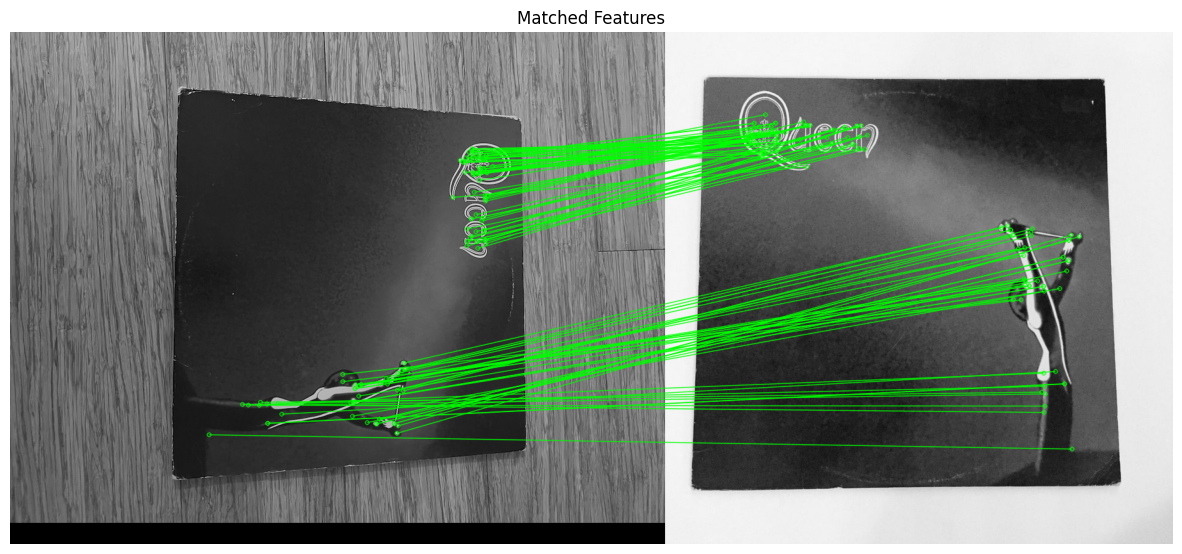

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two images
img1 = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images are loaded properly
if img1 is None or img2 is None:
    raise ValueError("Images not found or unable to load.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Use BFMatcher with cross-check to find matches
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test to filter out bad matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Number of initial matches: {len(good_matches)}")

# Extract location of good matches
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

# Apply RANSAC to find the homography matrix
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # 5.0 is a threshold value

# Convert the mask to boolean and extract the inlier matches
matchesMask = mask.ravel().tolist()
inliers = [m for i, m in enumerate(good_matches) if matchesMask[i]]

print(f"Number of inliers: {len(inliers)}")

# Create a new matchesMask that only includes inliers
new_matches_mask = [1 if matchesMask[i] else 0 for i in range(len(matchesMask))]

# Draw only the inliers on the image
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=new_matches_mask, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert images to BGR since we're drawing on them and they were loaded as grayscale
img1_bgr = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
img2_bgr = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

img3 = cv2.drawMatches(img1_bgr, kp1, img2_bgr, kp2, good_matches, None, **draw_params)

# Display using Matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying in Matplotlib
plt.axis('off')
plt.title('Matched Features')
plt.show()